In [373]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, recall_score, precision_score,make_scorer,classification_report,roc_curve
from sklearn.decomposition import PCA
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import xgboost as xgb
#import lightgbm as lgb
from catboost import CatBoostClassifier
np.random.seed(25)
import os
import warnings 
warnings.filterwarnings("ignore")

In [374]:
train = pd.read_csv('train_AUpWtIz/train.csv')
test = pd.read_csv('test_QyjYwdj.csv')
campaign_df = pd.read_csv('train_AUpWtIz/campaign_data.csv')
coupons = pd.read_csv('train_AUpWtIz/coupon_item_mapping.csv')
demographics = pd.read_csv('train_AUpWtIz/customer_demographics.csv')
transactions = pd.read_csv('train_AUpWtIz/customer_transaction_data.csv')
item_df = pd.read_csv('train_AUpWtIz/item_data.csv')

In [375]:
train.head()

id  campaign_id  coupon_id  customer_id  redemption_status
0   1           13         27         1053                  0
1   2           13        116           48                  0
2   6            9        635          205                  0
3   7           13        644         1050                  0
4   9            8       1017         1489                  0

In [376]:
train.shape

(78369, 5)

In [377]:
transactions.head()

date  customer_id  item_id  quantity  selling_price  other_discount  \
0  2012-01-02         1501    26830         1          35.26          -10.69   
1  2012-01-02         1501    54253         1          53.43          -13.89   
2  2012-01-02         1501    31962         1         106.50          -14.25   
3  2012-01-02         1501    33647         1          67.32            0.00   
4  2012-01-02         1501    48199         1          71.24          -28.14   

   coupon_discount  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

In [378]:
# New feature
# '-' because discounts are in negative
transactions['actual_price'] = transactions['selling_price'] - transactions['other_discount'] - transactions['coupon_discount']

In [379]:
# fill null values in demographics
demographics['no_of_children'].fillna('999999',inplace=True)
demographics['marital_status'].fillna('other',inplace=True)

In [380]:
cat_agg=['count','nunique']
num_agg=['min','max','mean','sum']
agg_col={
    'quantity':num_agg, 'selling_price':num_agg, 'other_discount':num_agg,'coupon_discount':num_agg,
       'brand':cat_agg, 'brand_type':cat_agg, 'category':cat_agg, 'age_range':cat_agg, 'marital_status':cat_agg,
    'rented':cat_agg, 'family_size':cat_agg, 'no_of_children':cat_agg, 'income_bracket':cat_agg
}
transactions = transactions.merge(item_df,how='left',on='item_id').merge(demographics,how='left',on='customer_id').groupby('customer_id').agg(agg_col).reset_index()

In [381]:
cat_agg=['count','nunique']
num_agg=['min','max','mean','sum']
agg_col={ 'brand':cat_agg, 'brand_type':cat_agg, 'category':cat_agg
}
coupons = coupons.merge(item_df,how='left',on='item_id').groupby('coupon_id').agg(agg_col).reset_index()

In [382]:
#coupons = coupons.merge(item_df,how='left',on='item_id')

def merged_df(df):
    df = df.merge(campaign_df,how='left',on='campaign_id')
    df = df.merge(coupons,how='left',on='coupon_id')
    df = df.merge(transactions,how='left',on='customer_id')
    return df

In [383]:
train_df = merged_df(train.copy())
test_df = merged_df(test.copy())

In [384]:
train_df['redemption_status'].value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

In [385]:
# Label encoding of categorical features
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
for i in train.columns:
    train_df['campaign_type'] = lb_make.fit_transform(train_df['campaign_type'])
    test_df['campaign_type'] = lb_make.fit_transform(test_df['campaign_type'])

In [386]:
train_df.head()

id  campaign_id  coupon_id  customer_id  redemption_status  campaign_type  \
0   1           13         27         1053                  0              0   
1   2           13        116           48                  0              0   
2   6            9        635          205                  0              1   
3   7           13        644         1050                  0              0   
4   9            8       1017         1489                  0              0   

  start_date  end_date  ('brand', 'count')_x  ('brand', 'nunique')_x  \
0   19/05/13  05/07/13                   125                       2   
1   19/05/13  05/07/13                     3                       1   
2   11/03/13  12/04/13                    67                       1   
3   19/05/13  05/07/13                     4                       1   
4   16/02/13  05/04/13                    32                       1   

             ...              (marital_status, count)  \
0            ...                                  310   
1            ...                                  385   
2            ...                                  970   
3            ...                                    0   
4            ...                                  562   

   (marital_status, nunique)  (rented, count)  (rented, nunique)  \
0                          1              310                  1   
1                          1              385                  1   
2                          1              970                  1   
3                          0                0                  0   
4                          1              562                  1   

   (family_size, count)  (family_size, nunique)  (no_of_children, count)  \
0                   310                       1                      310   
1                   385                       1                      385   
2                   970                       1                      970   
3                     0                       0                        0   
4                   562                       1                      562   

   (no_of_children, nunique)  (income_bracket, count)  \
0                          1                      310   
1                          1                      385   
2                          1                      970   
3                          0                        0   
4                          1                      562   

   (income_bracket, nunique)  
0                          1  
1                          1  
2                          1  
3                          0  
4                          1  

[5 rows x 48 columns]

In [387]:
train_df.isnull().sum(axis=0)

id                             0
campaign_id                    0
coupon_id                      0
customer_id                    0
redemption_status              0
campaign_type                  0
start_date                     0
end_date                       0
('brand', 'count')_x           0
('brand', 'nunique')_x         0
('brand_type', 'count')_x      0
('brand_type', 'nunique')_x    0
('category', 'count')_x        0
('category', 'nunique')_x      0
(quantity, min)                0
(quantity, max)                0
(quantity, mean)               0
(quantity, sum)                0
(selling_price, min)           0
(selling_price, max)           0
(selling_price, mean)          0
(selling_price, sum)           0
(other_discount, min)          0
(other_discount, max)          0
(other_discount, mean)         0
(other_discount, sum)          0
(coupon_discount, min)         0
(coupon_discount, max)         0
(coupon_discount, mean)        0
(coupon_discount, sum)         0
(brand_y, 

In [388]:
len(train_df.columns)

48

In [389]:
for col in train_df.columns:
    if len(train_df[col].unique()) == 1:
        train_df.drop(col,inplace=True,axis=1)
        test_df.drop(col,inplace=True,axis=1)

In [390]:
len(train_df.columns)

44

Four columns has been removed which had single value in all rows.

In [391]:
# drop_cols = []
# for i in train_df.columns:
#     for j in train_df.columns:
#         #print(i,j)
#         if (i!=j) and (train_df[i].equals(train_df[j])):
#             drop_cols.append(j)
            
# train_df.drop(drop_cols,inplace=True,axis=1)
# test_df.drop(drop_cols,inplace=True,axis=1)

In [392]:
train_df.columns

Index([                         'id',                 'campaign_id',
                         'coupon_id',                 'customer_id',
                 'redemption_status',               'campaign_type',
                        'start_date',                    'end_date',
              '('brand', 'count')_x',      '('brand', 'nunique')_x',
         '('brand_type', 'count')_x', '('brand_type', 'nunique')_x',
           '('category', 'count')_x',   '('category', 'nunique')_x',
                 ('quantity', 'max'),          ('quantity', 'mean'),
                 ('quantity', 'sum'),      ('selling_price', 'min'),
            ('selling_price', 'max'),     ('selling_price', 'mean'),
            ('selling_price', 'sum'),     ('other_discount', 'min'),
          ('other_discount', 'mean'),     ('other_discount', 'sum'),
          ('coupon_discount', 'min'),   ('coupon_discount', 'mean'),
          ('coupon_discount', 'sum'),          ('brand_y', 'count'),
              ('brand_y', 'nunique

In [393]:
# for i in train_df.columns:
#     try:
#         train_df[i] = np.log1p(train_df[x]+(min(train_df[x]) * -1))
#     except:
#         pass

In [394]:
# x = train_df.columns[20]
# sns.distplot((train_df[x]))
# plt.show()
# sns.distplot(np.log1p(train_df[x]+(min(train_df[x]) * -1)))
# plt.show()

In [395]:
train_df["start_date"] = (pd.to_datetime(train_df['start_date'], format="%d/%m/%y"))
test_df["start_date"] = (pd.to_datetime(test_df['start_date'], format="%d/%m/%y"))

train_df["end_date"] = (pd.to_datetime(train_df['end_date'], format="%d/%m/%y"))
test_df["end_date"] = (pd.to_datetime(test_df['end_date'], format="%d/%m/%y"))

In [396]:
train_df['end_date'].unique()

array(['2013-07-05T00:00:00.000000000', '2013-04-12T00:00:00.000000000',
       '2013-04-05T00:00:00.000000000', '2013-06-07T00:00:00.000000000',
       '2012-11-30T00:00:00.000000000', '2013-01-04T00:00:00.000000000',
       '2013-01-18T00:00:00.000000000', '2013-02-15T00:00:00.000000000',
       '2013-05-24T00:00:00.000000000', '2012-09-21T00:00:00.000000000',
       '2013-02-16T00:00:00.000000000', '2013-02-08T00:00:00.000000000',
       '2013-05-10T00:00:00.000000000', '2013-03-08T00:00:00.000000000',
       '2012-11-16T00:00:00.000000000', '2012-10-27T00:00:00.000000000',
       '2013-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [397]:
# train_df['end_date'].unique()
# train_df["campaign_month"] = train_df["start_date"].apply(lambda x: x.month)
# test_df["campaign_month"] = test_df["start_date"].apply(lambda x: x.month)
train_df["campaign_month"] = train_df["start_date"].apply(lambda dt: (dt.month%12 + 3)//3)
test_df["campaign_month"] = test_df["start_date"].apply(lambda dt: (dt.month%12 + 3)//3)

train_df['campaign_duration'] = (train_df['end_date'] - train_df['start_date'])
test_df['campaign_duration'] = (test_df['end_date'] - test_df['start_date'])

train_df['campaign_duration'] = train_df['campaign_duration'].apply(lambda x: x.days)
test_df['campaign_duration'] = test_df['campaign_duration'].apply(lambda x: x.days)

In [398]:
# #correlation matrix
# corrmat = train_df.corr()
# f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, square=True);

In [407]:
#len(train_df['customer_id'].unique())

1428

In [408]:
feature_names = [x for x in train_df.columns if x not in ['id','redemption_status',
                                                         'start_date','end_date']]
target = train_df['redemption_status']

In [400]:
# # Modeling
# model = xgb.XGBClassifier(n_estimators=200,max_depth=6)

# ## Cross Validation
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import r2_score, make_scorer
# cv_score = cross_val_score(model, train_df[feature_names], target, cv=5, scoring='roc_auc')
# print(cv_score.mean() * 100)

Accuracy:  0.9910680107183871
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15528
           1       0.64      0.10      0.17       146

    accuracy                           0.99     15674
   macro avg       0.81      0.55      0.58     15674
weighted avg       0.99      0.99      0.99     15674

AUROC Plot: 0.9400


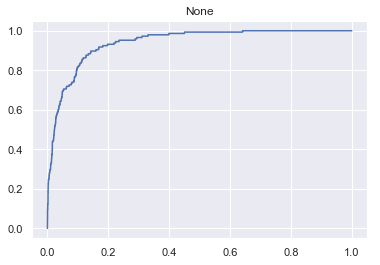

In [409]:
x_train, x_test, y_train, y_test = train_test_split(train_df[feature_names].values, target,
                                                    test_size=0.2,
                                                    random_state=2019,stratify=target)
model = xgb.XGBClassifier(n_estimators=150,max_depth=6)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Accuracy: ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# AUC ROC CURVE
predictions = model.predict_proba(x_test)[:,1]
roc_auc_score(y_test, y_pred, average='weighted')

fpr, tpr, threshold = roc_curve(y_test, predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
pltTitle = print("AUROC Plot:", "%.4f" %auc)

# Plotting the ROC Curve
plt.plot(fpr,tpr)
plt.title(pltTitle)
plt.show()

In [410]:
model = xgb.XGBClassifier(n_estimators=200,max_depth=6)
model.fit(train_df[feature_names],target)
pred = model.predict_proba(test_df[feature_names])

In [411]:
## make submission
sub = pd.DataFrame()
sub['id'] = test['id']
sub['redemption_status'] = [i[1] for i in pred]
sub.to_csv('result.csv', index=False)

In [412]:
sub.head()

id  redemption_status
0   3           0.124100
1   4           0.000792
2   5           0.100245
3   8           0.000093
4  10           0.000056